In [1]:
"""
Try to visualise what is going on with adverserial examples in 2d. Using tf is 
overkill for this but it lets me reuse my code easily
"""
%matplotlib notebook
import tensorflow as tf
import keras
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model, save_model
from keras import backend as K
import itertools as itr
from cleverhans.attacks_tf import fgm
import os
import argparse
import sys
sys.path.append('..')
from src.utilities import *
import scipy.special

Using TensorFlow backend.


This notebook is to try to visualise what is going on with the BALD and entropy of models on adverserial examples, hopefully to gain some intuition into what is going on, on a 2D toy dataset.

Note that in high dimensions, these blobs may not be a very faithful representation of the distribution of datapoints. In particular, there is the well known result that most of the volume of a high dimensional volume is concentrated in a thin shell near the surface; to see this, recall that a the n-ball of radius r

$$
\mathcal{B}^n = \{ x \in \mathbb{R}^n : \| x \|_2 \leq r \}
$$

has a volume $$V_{ball} =K(n) r^n$$ where $$K(n)$$ is a constant that depends on the dimensionality only. Now, consider the fraction of the volume of the sphere that is inside the shell close to the boundary

$$
\mathcal{S}^n = \{ x \in \mathbb{R}^n : c r \lt \| x \|_2 \leq r \} \; \text{where} \; c \in [0,1]
$$

The volume of this shell is given simply by
$$
V_{shell} = K(n) ( r^n - (c r)^n)
$$

and so the fraction of the volume of the ball that is in the shell is

$$
\frac{V_{shell}}{V_{ball}} = \frac{ r^n - (c r)^n} {r^n} = 1 - c^n
$$

That is, as 

$$n \to \infty,\;\frac{V_{shell}}{V_{ball}} \to 1$$

For example, in 1000 dimensional space, the fraction of the sphere that is within 0.01 r from the surface of the sphere is 0.999957. It is easy to show that a similar result holds for an n-cube. The relevance to adverserial examples is that, for any fixed partitioning of the feature space into decision cells, the majority of points are in some sense close to a boundary, which isn't true in 2d.

I've also tried to project the example onto a manifold in decision space; there is only really one degree of freedom in the sample generation, and the samples are then fed through an arbitrary projection (I used a bessel function) so they don't lie on a straight line. Again, this is interesting because images are widely belived to lie on complex low dimensional manifolds in decision space; ideally our network should have high uncertainty away from the manifold of the data. 

<IPython.core.display.Javascript object>


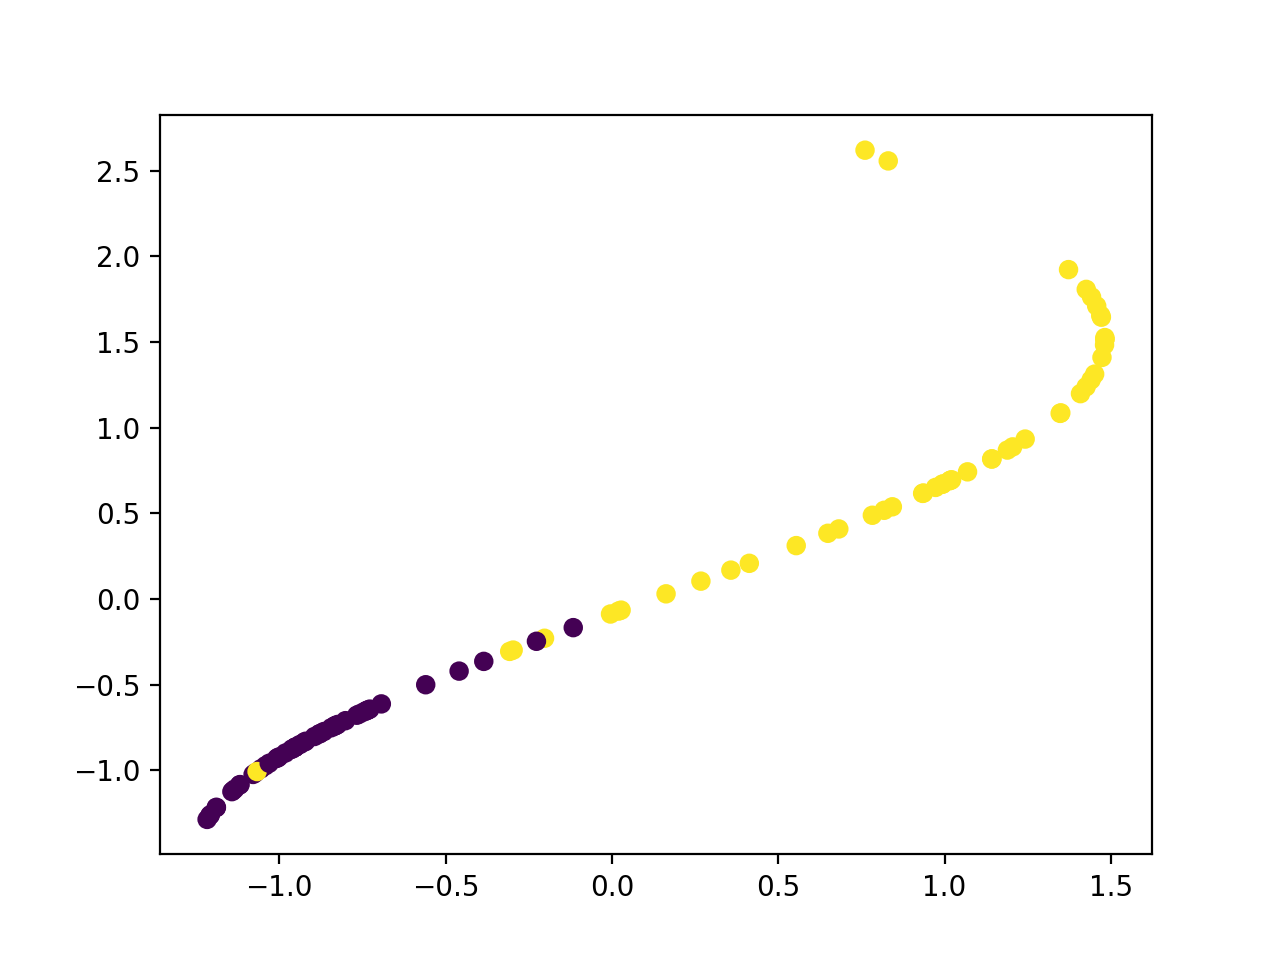

In [2]:
from sklearn.datasets import make_classification
N_c = 2 #number of classes
data,labels = make_classification(n_classes=N_c, n_features=2, n_redundant=1,n_informative=1, n_clusters_per_class=1, class_sep = 1)
data[:,0] = scipy.special.j1(data[:,0]) #this could be any function really. 
data -= data.mean(axis=0)
data /= data.std(axis=0)
plt.figure()
plt.scatter(data[:,0], data[:,1], c=labels)

Watch out when running the above; sometimes the make_classification function randomly flips points, so that the classes are not seperable. This is fine, but because there is only one real independent direction here sometimes the points are covered up, which can make the resultant decision boundaries look a little bit confusing.
(Yarin: I think this is what was making the BALD and entropy asymmetric the other day.)

In [19]:
from src.concrete_dropout import ConcreteDropout
from keras.layers import Dense
K.set_learning_phase(True)
weight_decay = 1e-3
h_act = 'relu' #anything here really
inputs = keras.layers.Input(shape=(2,))

h1 = Dense(500, activation=h_act)(inputs)

h2 = ConcreteDropout(Dense(500, activation=h_act), weight_regularizer=weight_decay)(h1)


predictions = ConcreteDropout(Dense(N_c, activation='softmax'))(h2)
#predictions = Dense(N_c, activation='softmax')(h2)
model = keras.models.Model(inputs=inputs, outputs=predictions)

model.compile(
    optimizer='sgd',
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy'])

class TrackConcreteDropoutP(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.ps = []
        self.losses = []
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        ps_tensor = [x.p for x in model.layers if 'concrete_dropout' in x.name] #all the concrete dropout layers
        get_ps = K.function([], ps_tensor)
        p = get_ps([])
        self.ps.append(p)
        print(" ", p)
        return
 
    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        return


In [ ]:
'concrete_dropout' in model.layers[3].name

In [20]:
x = data
y = keras.utils.to_categorical(labels)
model.fit(x,y, epochs=500, callbacks = [TrackConcreteDropoutP()])

Epoch 1/500
100/100 [==============================] - 0s - loss: 1.2304 - acc: 0.7000     
Epoch 2/500
100/100 [==============================] - 0s - loss: 1.1978 - acc: 0.9200     
Epoch 3/500
100/100 [==============================] - 0s - loss: 1.1767 - acc: 0.9300     
Epoch 4/500
100/100 [==============================] - 0s - loss: 1.1509 - acc: 0.9300     
Epoch 5/500
100/100 [==============================] - 0s - loss: 1.1299 - acc: 0.9300     
Epoch 6/500
100/100 [==============================] - 0s - loss: 1.1116 - acc: 0.9300     
Epoch 7/500
100/100 [==============================] - 0s - loss: 1.0937 - acc: 0.9300     
Epoch 8/500
100/100 [==============================] - 0s - loss: 1.0702 - acc: 0.9400     
Epoch 9/500
100/100 [==============================] - 0s - loss: 1.0548 - acc: 0.9400     
Epoch 10/500
100/100 [==============================] - 0s - loss: 1.0357 - acc: 0.9300     
Epoch 11/500
100/100 [==============================] - 0s - loss: 1.0200 - acc

KeyboardInterrupt: 

I haven't tuned the learning rate or network hyperparameters at all, so don't take this as gospel. Now I've added concrete dropout it seems to behave pretty sensibly though. This is n't a very big network but it's not a very hard problem either.

In [5]:
#set up tensors to represent variables of interest
n_mc = 50

mc_preds_tensor = mc_dropout_preds(model, inputs, n_mc=n_mc)
entropy_mean_tensor = predictive_entropy(mc_preds_tensor)
bald_tensor = BALD(mc_preds_tensor)
mean_mc_preds = K.mean(mc_preds_tensor, axis=0)
mc_pred_class = K.one_hot(K.argmax(mean_mc_preds, axis=1), N_c) #current predicted class

loss_tensor = model.loss(mc_pred_class, mean_mc_preds) #loss of current predicted class
input_grad_tensor = K.gradients(loss_tensor, [inputs])
get_output = K.function([inputs], [K.mean(mc_preds_tensor, axis=0), 
                              entropy_mean_tensor,
                              bald_tensor,
                              input_grad_tensor[0]])

<IPython.core.display.Javascript object>


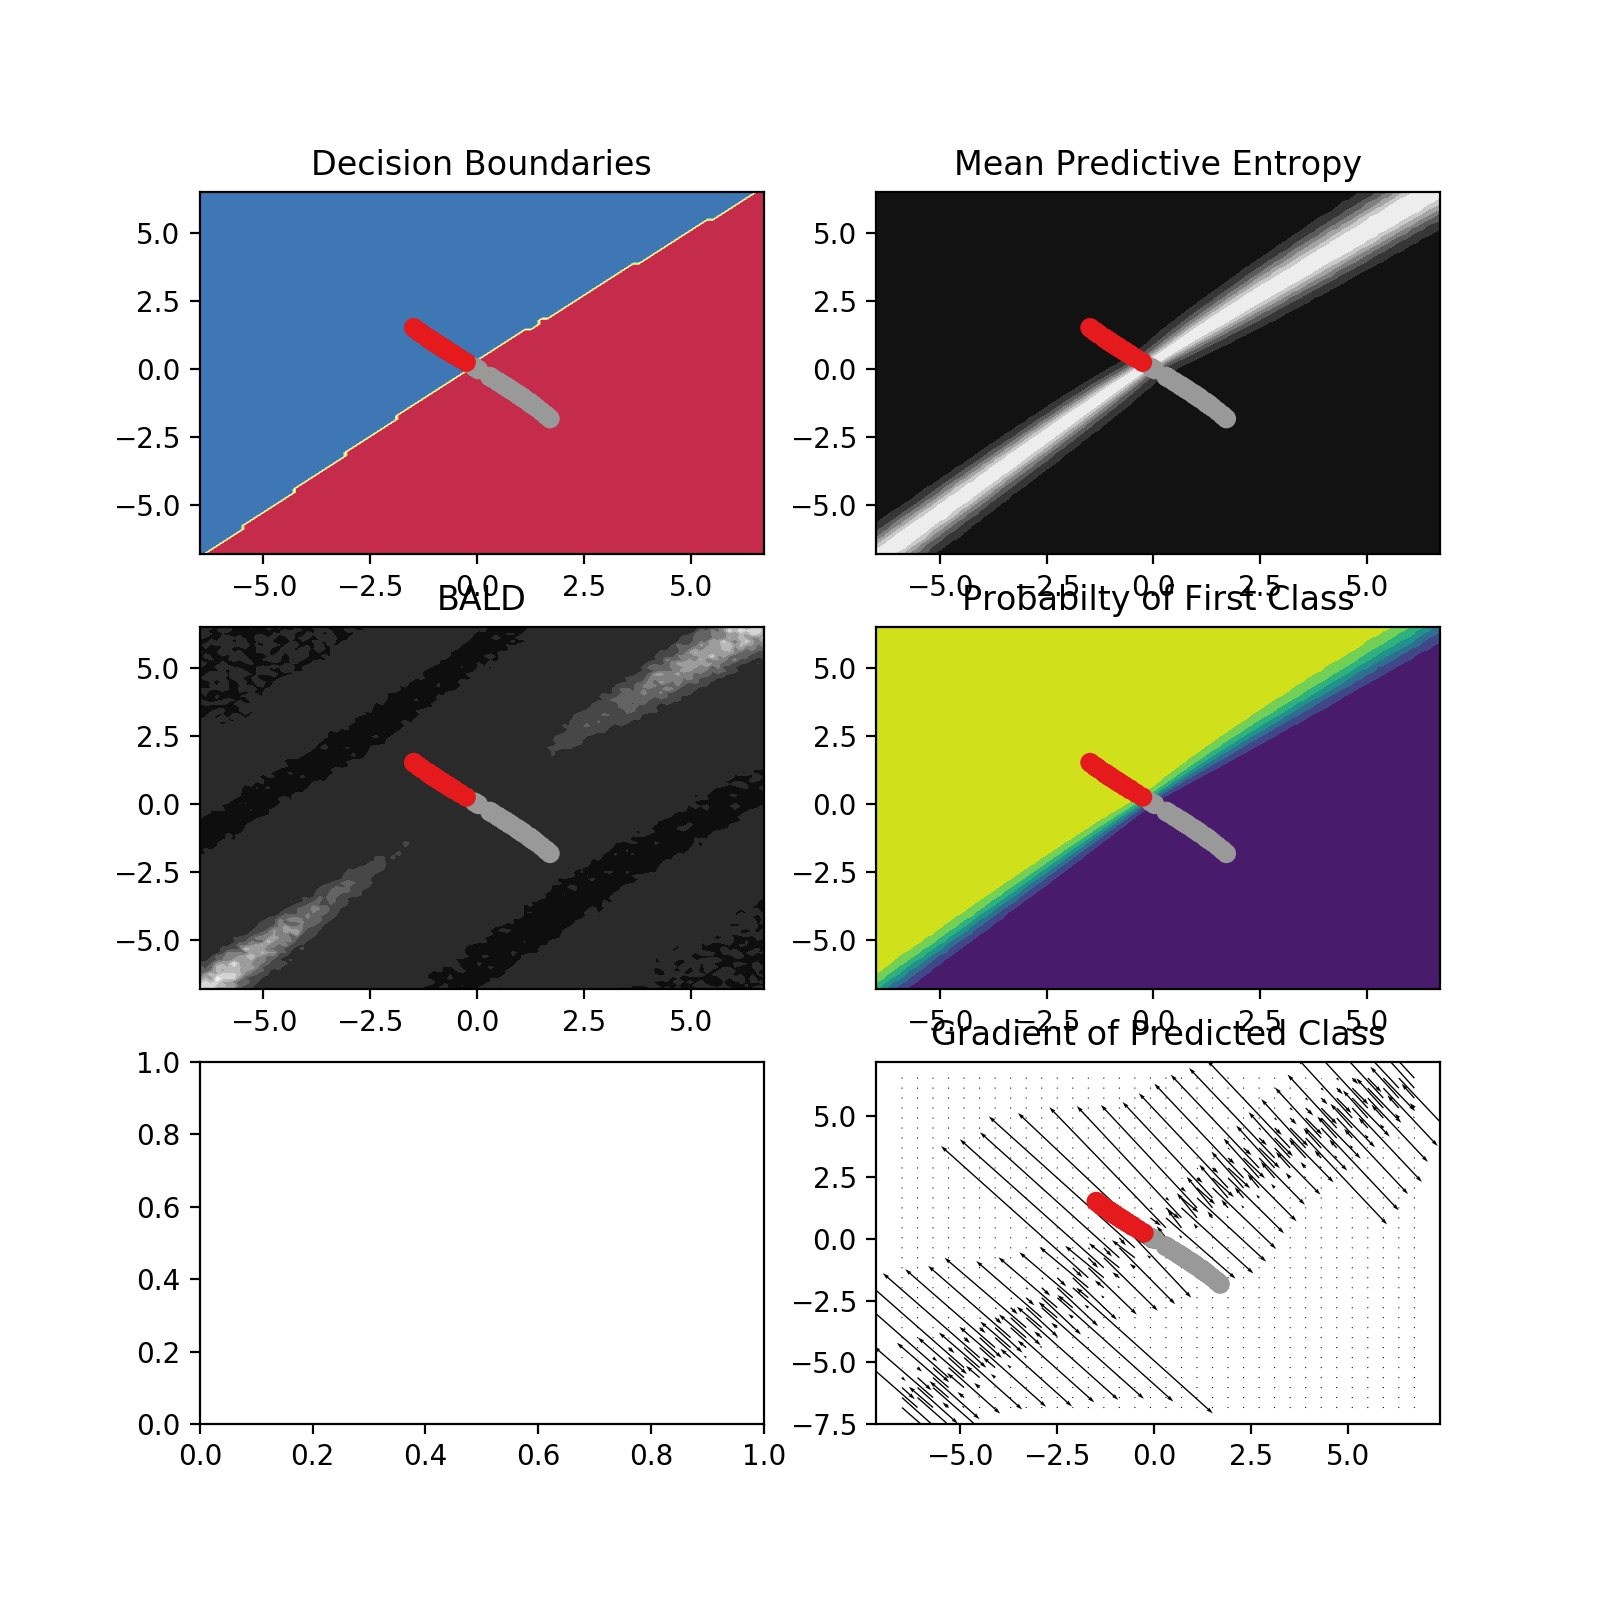

In [6]:
plt.rcParams['figure.figsize'] = 8,8
around = 5
xx,yy = np.meshgrid(np.linspace(data[:,0].min() -around,data[:,0].max() + around, 100),
                    np.linspace(data[:,1].min()-around,data[:,1].max()+around, 100))

plot_x = np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)], axis=1)
plot_probs, plot_entropy, plot_bald, plot_grad = get_output([plot_x])
plot_preds = np.argmax(plot_probs, axis=1).reshape(xx.shape)

# plt.figure()
# plt.contourf(xx,yy,plot_decision_bounds, cmap=plt.cm.Set1)
# plt.scatter(data[:,0],data[:,1], c=labels, cmap=plt.cm.Set1_r); plt.show()

def mk_plots(xx, yy, x, y, probs, entropy, bald, grad):
    decision = probs.argmax(axis=1)
    
    f, ax = plt.subplots(3,2)
    backgrounds = [ decision, entropy , bald , probs[:,1]]
    titles = ['Decision Boundaries', 'Mean Predictive Entropy', 'BALD','Probabilty of First Class']
    backcols = [plt.cm.Spectral, plt.cm.gray, plt.cm.gray, plt.cm.viridis]
    axlist = [a for a in ax.flatten()]
    for (ax, field,c, title) in zip(axlist, backgrounds, backcols, titles):
        ax.contourf(xx,yy, field.reshape(xx.shape), cmap=c)
        ax.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.Set1_r)
        ax.set_title(title)
    
    grad_x = grad[:,0].reshape(xx.shape)
    grad_y = grad[:,1].reshape(xx.shape)
    
    #downsample for the quiver plot
    xx = xx[::3,::3]
    yy = yy[::3,::3]
    grad_x = grad_x[::3,::3]
    grad_y = grad_y[::3,::3]
    
    axlist[-1].quiver(xx,yy,grad_x, grad_y)
    axlist[-1].scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.Set1_r)
    axlist[-1].set_title('Gradient of Predicted Class')
mk_plots(xx,yy,data,labels,plot_probs,plot_entropy,plot_bald, plot_grad)

Dropout seems to prefer entropy aligned with the axis vectors. Suppose this is because it sets whole columns to zero? This seems to back up our idea that the BALD is strictly less then the entropy, though this doesn't of course mean it's distribution is the same. Notably though, the bald seems to be *low* near the decision boundaries, wheras the entropy is always high. This is sensible for an aquisition function, but possibly not so great for finding adversarial examples.

In [20]:
#sanity check; redo the above in plain numpy.
def entropy(X):
    return np.sum(- X * np.log(X.clip(0, 1.0)), axis=-1) #avoid log 0

def bald_score(mc_preds):
    mean_preds = mc_preds.mean(axis=0)
    entropy_of_mean = entropy(mean_preds)
    
    mean_of_entropy = np.mean(entropy(mc_preds), axis=0)
    return entropy_of_mean - mean_of_entropy


mc_forward = np.array([model.predict(plot_x) for _ in range(50)])
plot_preds = mc_forward.mean(axis=0)
plot_class = plot_preds.argmax(axis=1)
plot_entropy = entropy(plot_preds)
plot_mean_of_entropy = entropy(mc_forward).mean(axis=0)
plot_bald = bald_score(mc_forward)

<IPython.core.display.Javascript object>


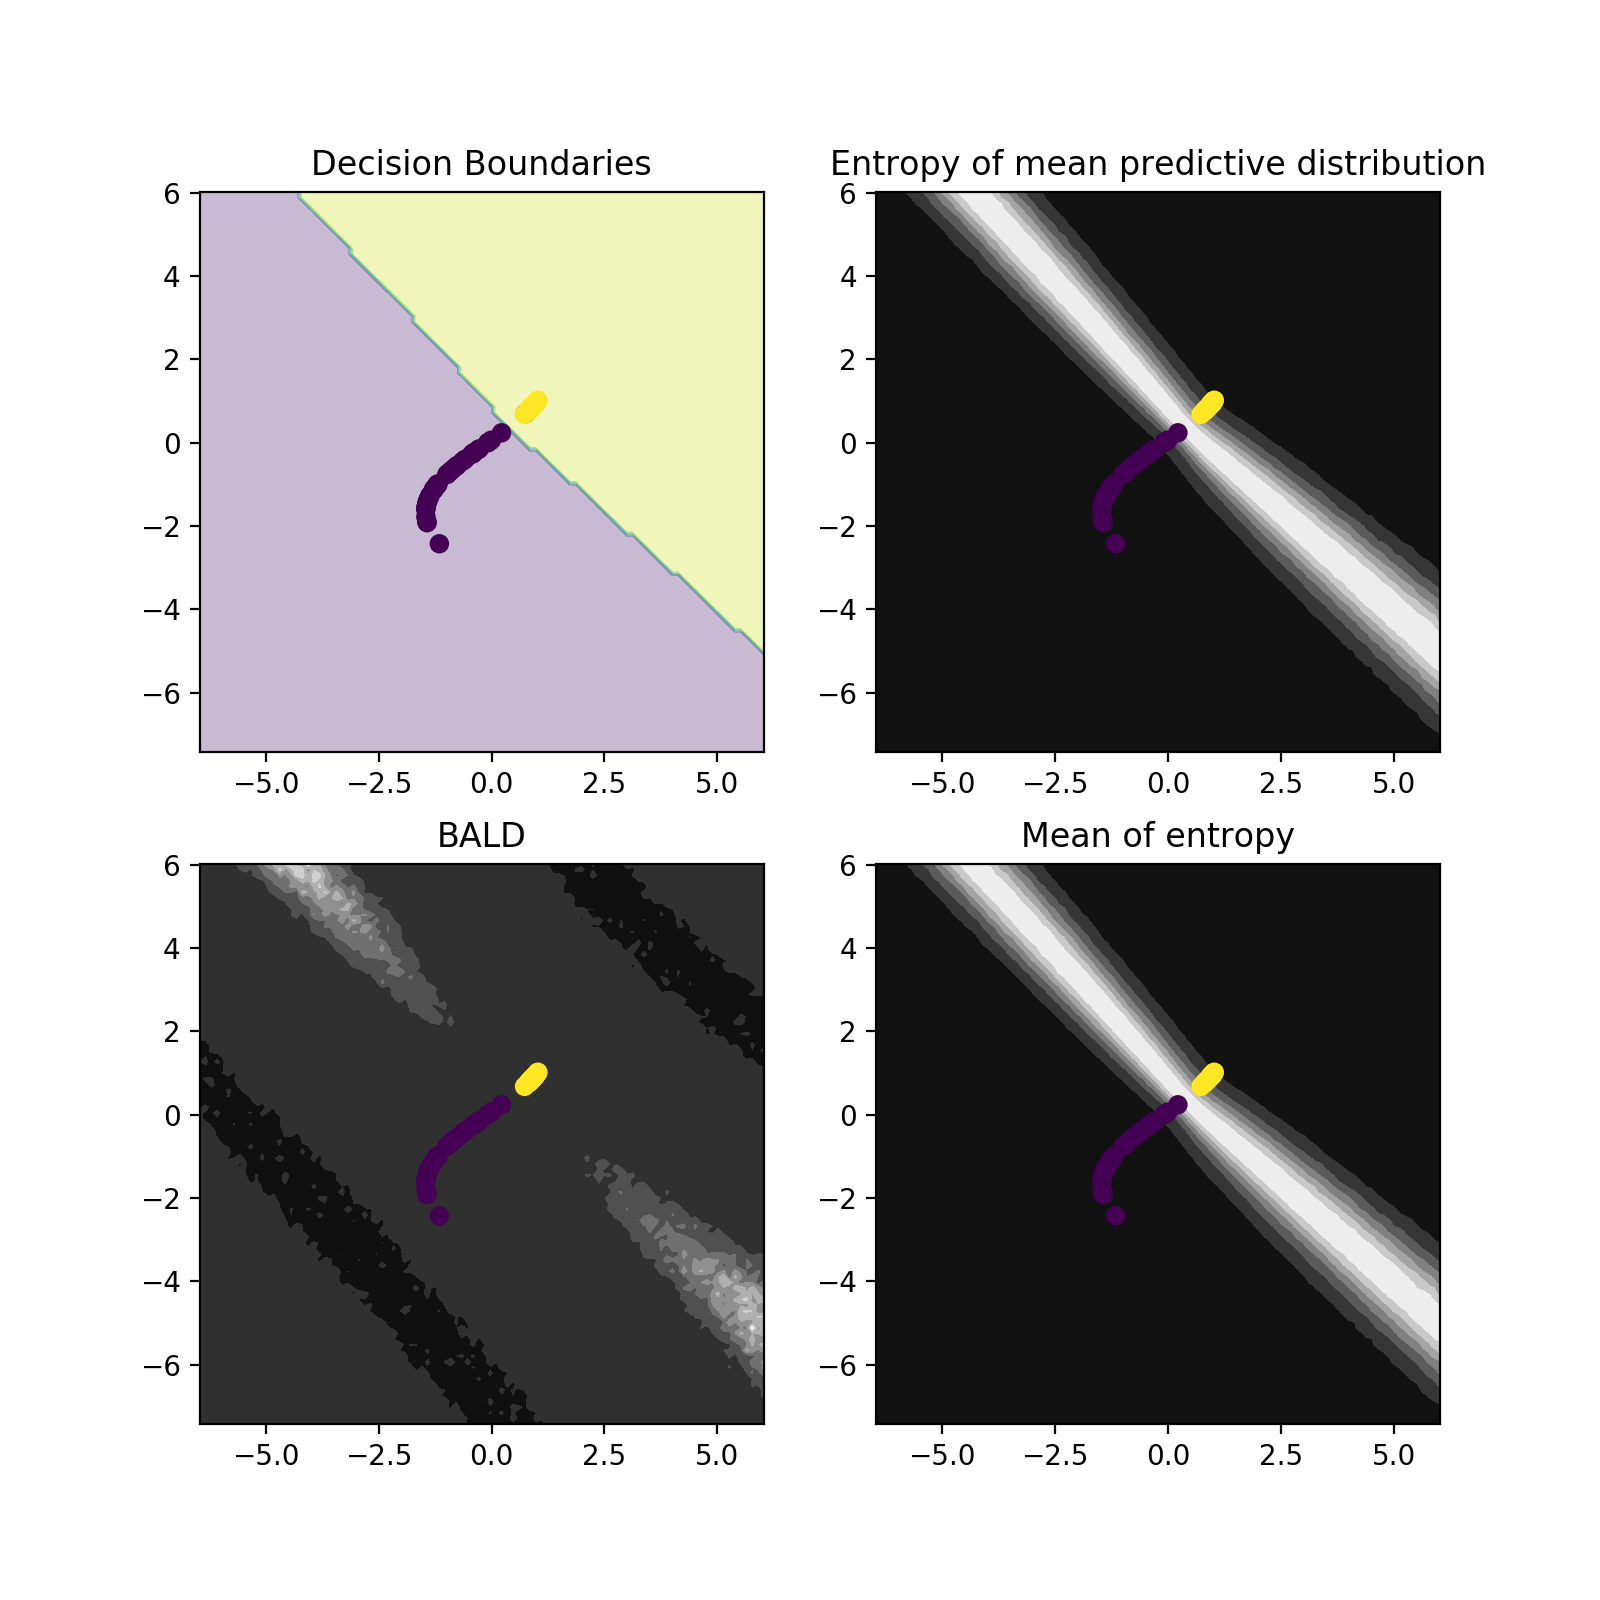

In [26]:
f, sp = plt.subplots(2,2)
sp[0,0].contourf(xx,yy,plot_class.reshape(xx.shape), alpha = 0.3)
sp[0,0].set_title('Decision Boundaries')
sp[0,1].contourf(xx,yy, plot_entropy.reshape(xx.shape), cmap = 'gray')
sp[0,1].set_title('Entropy of mean predictive distribution')
sp[1,0].contourf(xx,yy,plot_bald.reshape(xx.shape), cmap = 'gray')
sp[1,0].set_title('BALD')
sp[1,1].contourf(xx,yy,plot_mean_of_entropy.reshape(xx.shape), cmap = 'gray')
sp[1,1].set_title('Mean of entropy')
for a in sp.flatten():
    a.scatter(data[:,0], data[:,1], c = labels)
plt.show()

In [25]:
print(plot_entropy.max(), plot_entropy.min())
print(plot_mean_of_entropy.max(), plot_mean_of_entropy.min())
print(plot_bald.max(), plot_bald.min())

0.693145 1.63472e-12
0.691735 1.58541e-12
0.0270712 -3.35387e-07


In [27]:
0.027 / 0.69

0.0391304347826087

So, here is an explanation for why using the 'wrong' mean of the entropy produces almost the same results; they are nearly identical! 

<IPython.core.display.Javascript object>


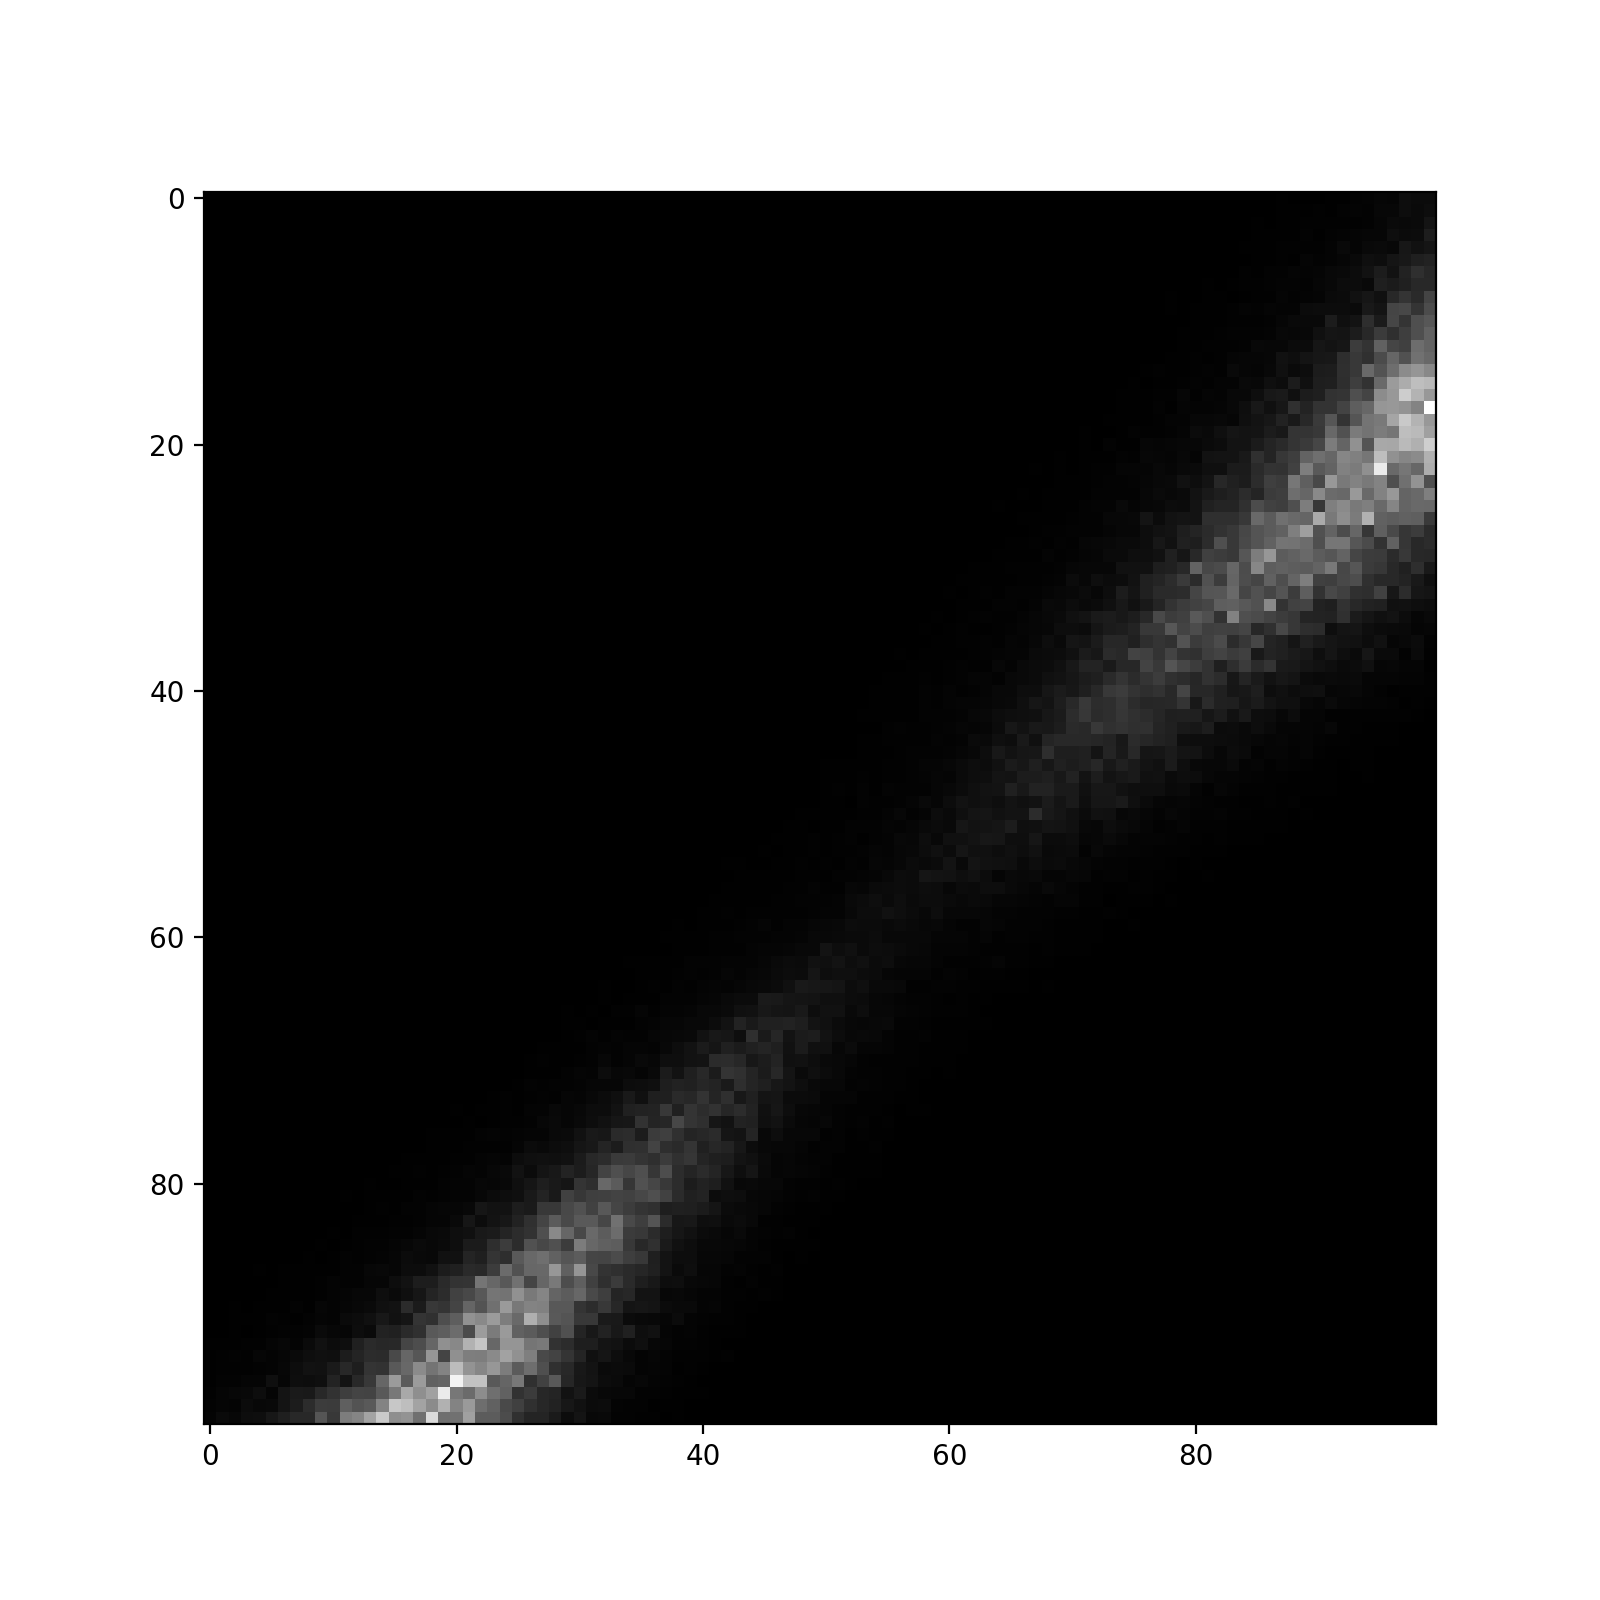

In [19]:
plt.figure()
plt.imshow(plot_bald.reshape(xx.shape), cmap = 'gray'); 
#plt.scatter(data[:,0], data[:,1], c=labels)
plt.show()


The above plots show 4 characteristics of the output of the softmax layer of a neural network on this toy problem. The first shows the decision boundaries, which partition the data space into regions assigned to one of the three classes, choosing classes according to 

$$
\begin{align}
y_{predicted} &= \arg\max_{c} p(y_c \mid x, D) \\
              &= \arg\max_{c} \int p(y_c \mid \theta, x) p(\theta \mid D) d \theta \\
            &\simeq \arg\max_{c} \sum_{i=1}^{N_{mc}} p(y_c \mid x, \theta), \;\; \theta \sim q(\theta)
\end{align}
$$
where q is the (dropout) variational approximation to the true posterior over theta. Let us define
$$
p_{dropout}(y) := \sum_{i=1}^{N_{mc}} p(y_c \mid x, \theta), \;\; \theta \sim q(\theta)
$$
for the predictions of our model. The second two plots are two methods for evaluating the certainty of a classification model; the first is simply to look at the entropy 
$$
\text{H} = \sum_{x \in \mathcal{X}} p(x) \frac{1}{\log p(x)}
$$
of the predictive distribution. This is high when our predictive distribution spreads its mass uniformly over classes, and low when all the probability is concentrated in a single class. As can be seen above, this mostly recovers the area in the vicinity of the decision boundaries, since the predictive entropy is significant only when the softmax is non-saturating. The second measure is the 'BALD' (baysian active learning by disagreement) score, which was proposed initially as an aquisition function in reinforcement learning.
Recall that the _mutual information_ between two random variables X and Y is defined as 

$$
I(X,Y) = \text{H}(p(X)) - \mathbb{E}_{p(Y)}[ \text{H}(p(X \mid Y)) ]
$$

Now, consider the mutual information between the paramters and a new observation y, conditioned on the data and the input x;

$$
I(y, \theta \mid D, x) = \text{H}(p(y \mid D, x)) -  \mathbb{E}_{p(\theta \mid D, x)}[ \text{H}(p(y \mid x, \theta, D)) ]
$$

Consider the model parameters and D fixed and consider this as function of x only. What this function gives us is a measure of which values of x would provide the highest amount of information about the parameters if we had the correct output corresponding to x. Another way of stating this is that this function is high for x where we are uncertain about the model parameters (since these obtaining labels for these points would give us a high information gain).

This usefulness of this quantity as an aquisition function should be clear; now consider it as a measure of model uncertainty. Unlike the entropy, mutual information distinguishes between _aleatoric_ and _epistemic_ uncertainty. There are two reasons our predictive distribution may be uncertain; because our model parameters are poorly determined (epistemic) or because our data is inherently noisy (aleatoric). In the case of noisy data, even a very well determined model ought to have a high predictive entropy. On the other hand, for poorly determined parameters, many samples from the posterior over parameters will have low entropy, but the predictions will be different for different samples. The BALD score prefers epistemic uncertainty; in the case of a well determined model where the predictions have high entropy because of inherent stochasticity, the first term will be high, but cruicially the entropy will also be high for any sample from the parameter posterior, so it will be cancelled out by the second term. On the other hand, if the parameters are uncertain, the predictive distribution will still have high entropy, but any individual set of parameters is likely to have low entropy, so the second term will be small.

For the case of a dropout network, the expectations and integration over parameters in the calculation of the BALD score must be approximated by empirical means over samples from the variational distribution; it reduces to the difference between the entropy of the mean of these samples and the mean of the entropy. 

$$
BALD(x) = \text{H}(p_{dropout}(y)) - \frac{1}{N_{MC}} \sum_{i=1}^{N_{MC}} \text{H} (p(y_c \mid x, \theta)), \;\; \theta \sim q(\theta)
$$

The final panel shows the gradient of the cross entropy assuming that the current model classification is correct with respect to the input. That is, if 
$$
\hat{y} = \arg \max_c p_{dropout}(y_c)
$$
Then we plot 
$$
\nabla_{x} \mathcal{J}(\hat{y}, p_{dropout}(y_c))
$$
where 
$$
\mathcal{J}(y,y')
$$
is the cross entropy loss (in this case). This gives a direction in which the model's output is most sensitive to changes in the input. This gradient information is used by many adversarial example generation algorithms. The simplest one is the Fast Gradient Method, which takes a single step in the direction of this gradient.

These reveal some interesting properties in this 2D example. As might be expected, the entropy is high near the decision boundaries and low more or less everywhere else; this is likely because of the saturation of the softmax. The BALD score is less uniform; it is high only near decision boundaries that are far from the data. Notably, it is *not* high everywhere that is far from the data; this is a drawback, likely because our variational approximation only really explores close to a local mode; by eye, there are clearly ways of drawing decision planes that shatter the above dataset that are not explored by this approximation.

There may be a simple explanation for why entropy is often a better discriminator on FGM adversarial examples; as these show, the BALD score is strictly lower than the entropy of a MC dropout classifier

$$
BALD(x) = \text{H}(p_{dropout}(y)) - \mathbb{E}_{q(\theta)} \text{H} (p(y | \theta)) \leq \text{H}(p_{dropout}(y))
$$

since the entropy is greater than or equal zero (for a discrete distribution such as p(y))

<IPython.core.display.Javascript object>


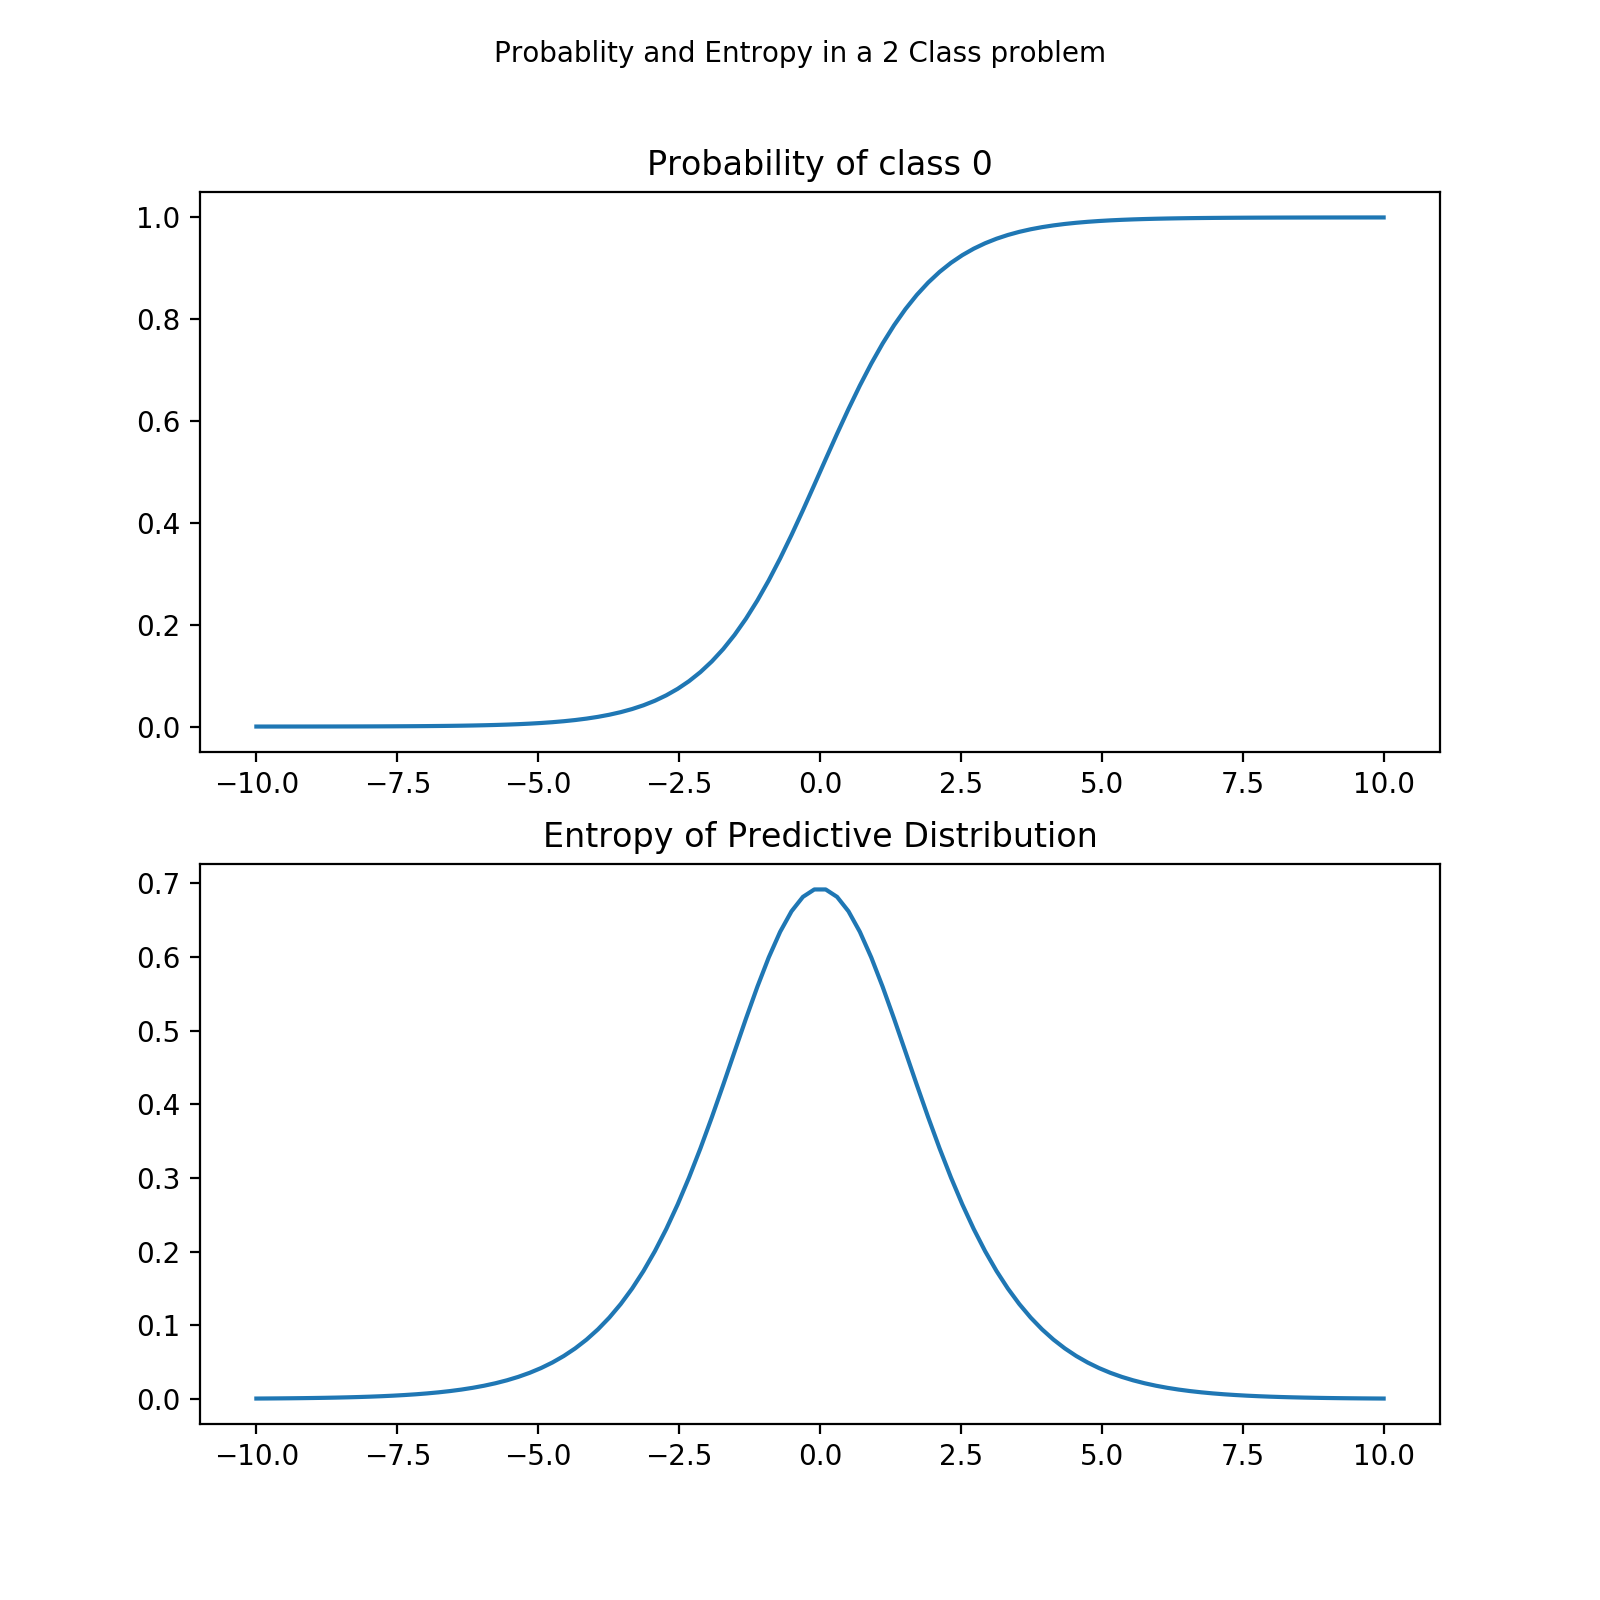

In [60]:
x = np.linspace(-10,10,100)
prob_x = 1 / (1 + np.exp(-x))
f, ax = plt.subplots(2,1)
ax[0].plot(x, prob_x)
ax[0].set_title('Probability of class 0')
entropy_x = - prob_x * np.log(prob_x) - (1 - prob_x) * np.log(1 - prob_x)
ax[1].plot(x,entropy_x)
ax[1].set_title('Entropy of Predictive Distribution')
f.text(0.5, 0.975, 'Probablity and Entropy in a 2 Class problem',
         horizontalalignment='center', verticalalignment='top')
plt.show()

<IPython.core.display.Javascript object>


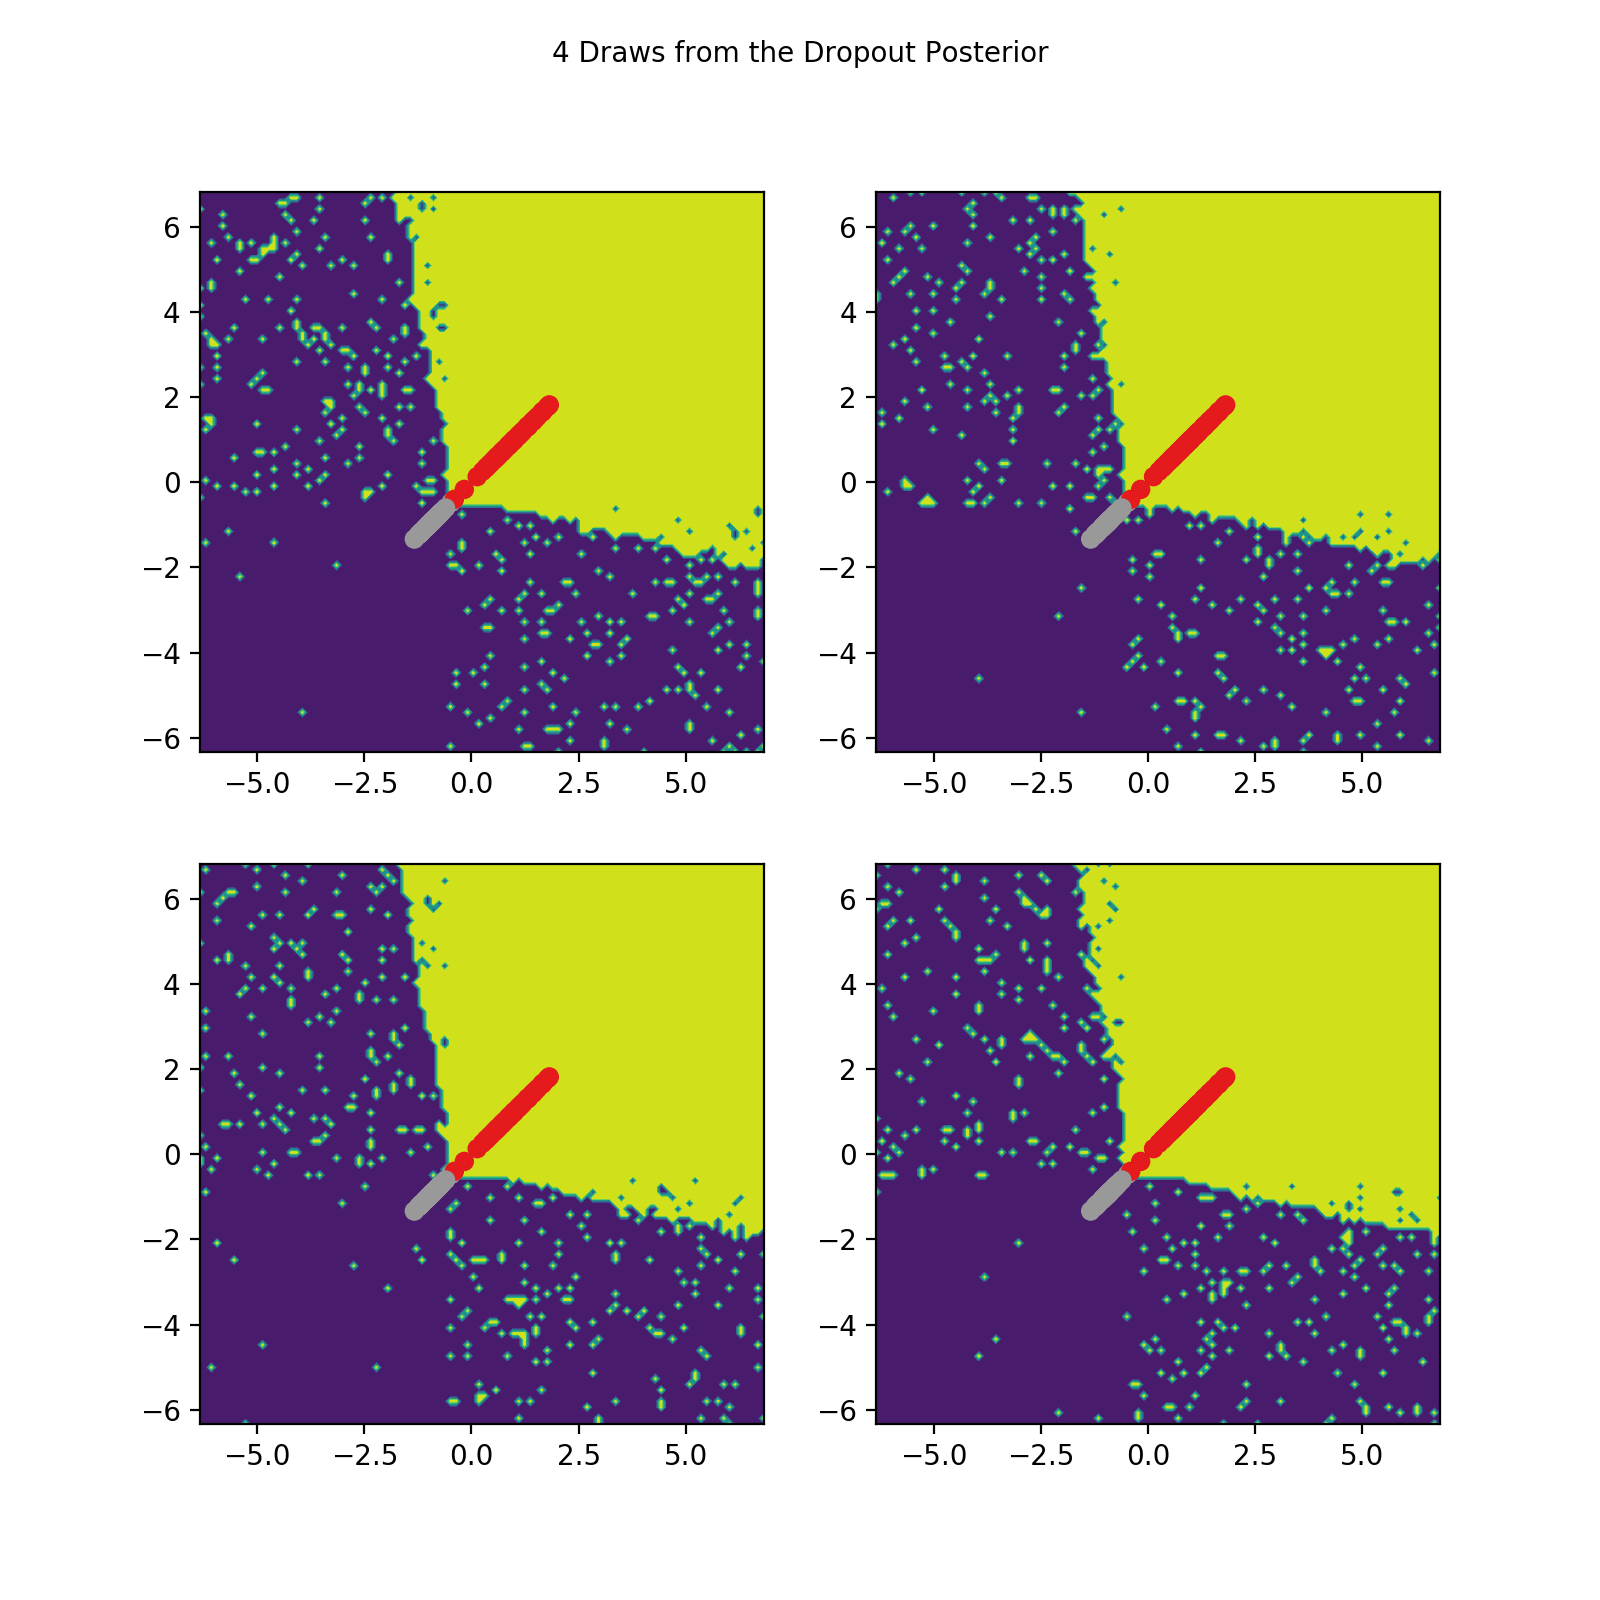

Text(0.5,0.975,'4 Draws from the Dropout Posterior')

In [6]:
preds = [model.predict(plot_x).argmax(axis=1).reshape(xx.shape) for _ in range(4)]
f, ax = plt.subplots(2,2)
for (a, p) in zip(ax.flatten(), preds):
    a.contourf(xx,yy,p)
    a.scatter(data[:,0], data[:,1], c=labels, cmap=plt.cm.Set1_r)
f.text(0.5, 0.975, '4 Draws from the Dropout Posterior',
         horizontalalignment='center', verticalalignment='top')

<IPython.core.display.Javascript object>


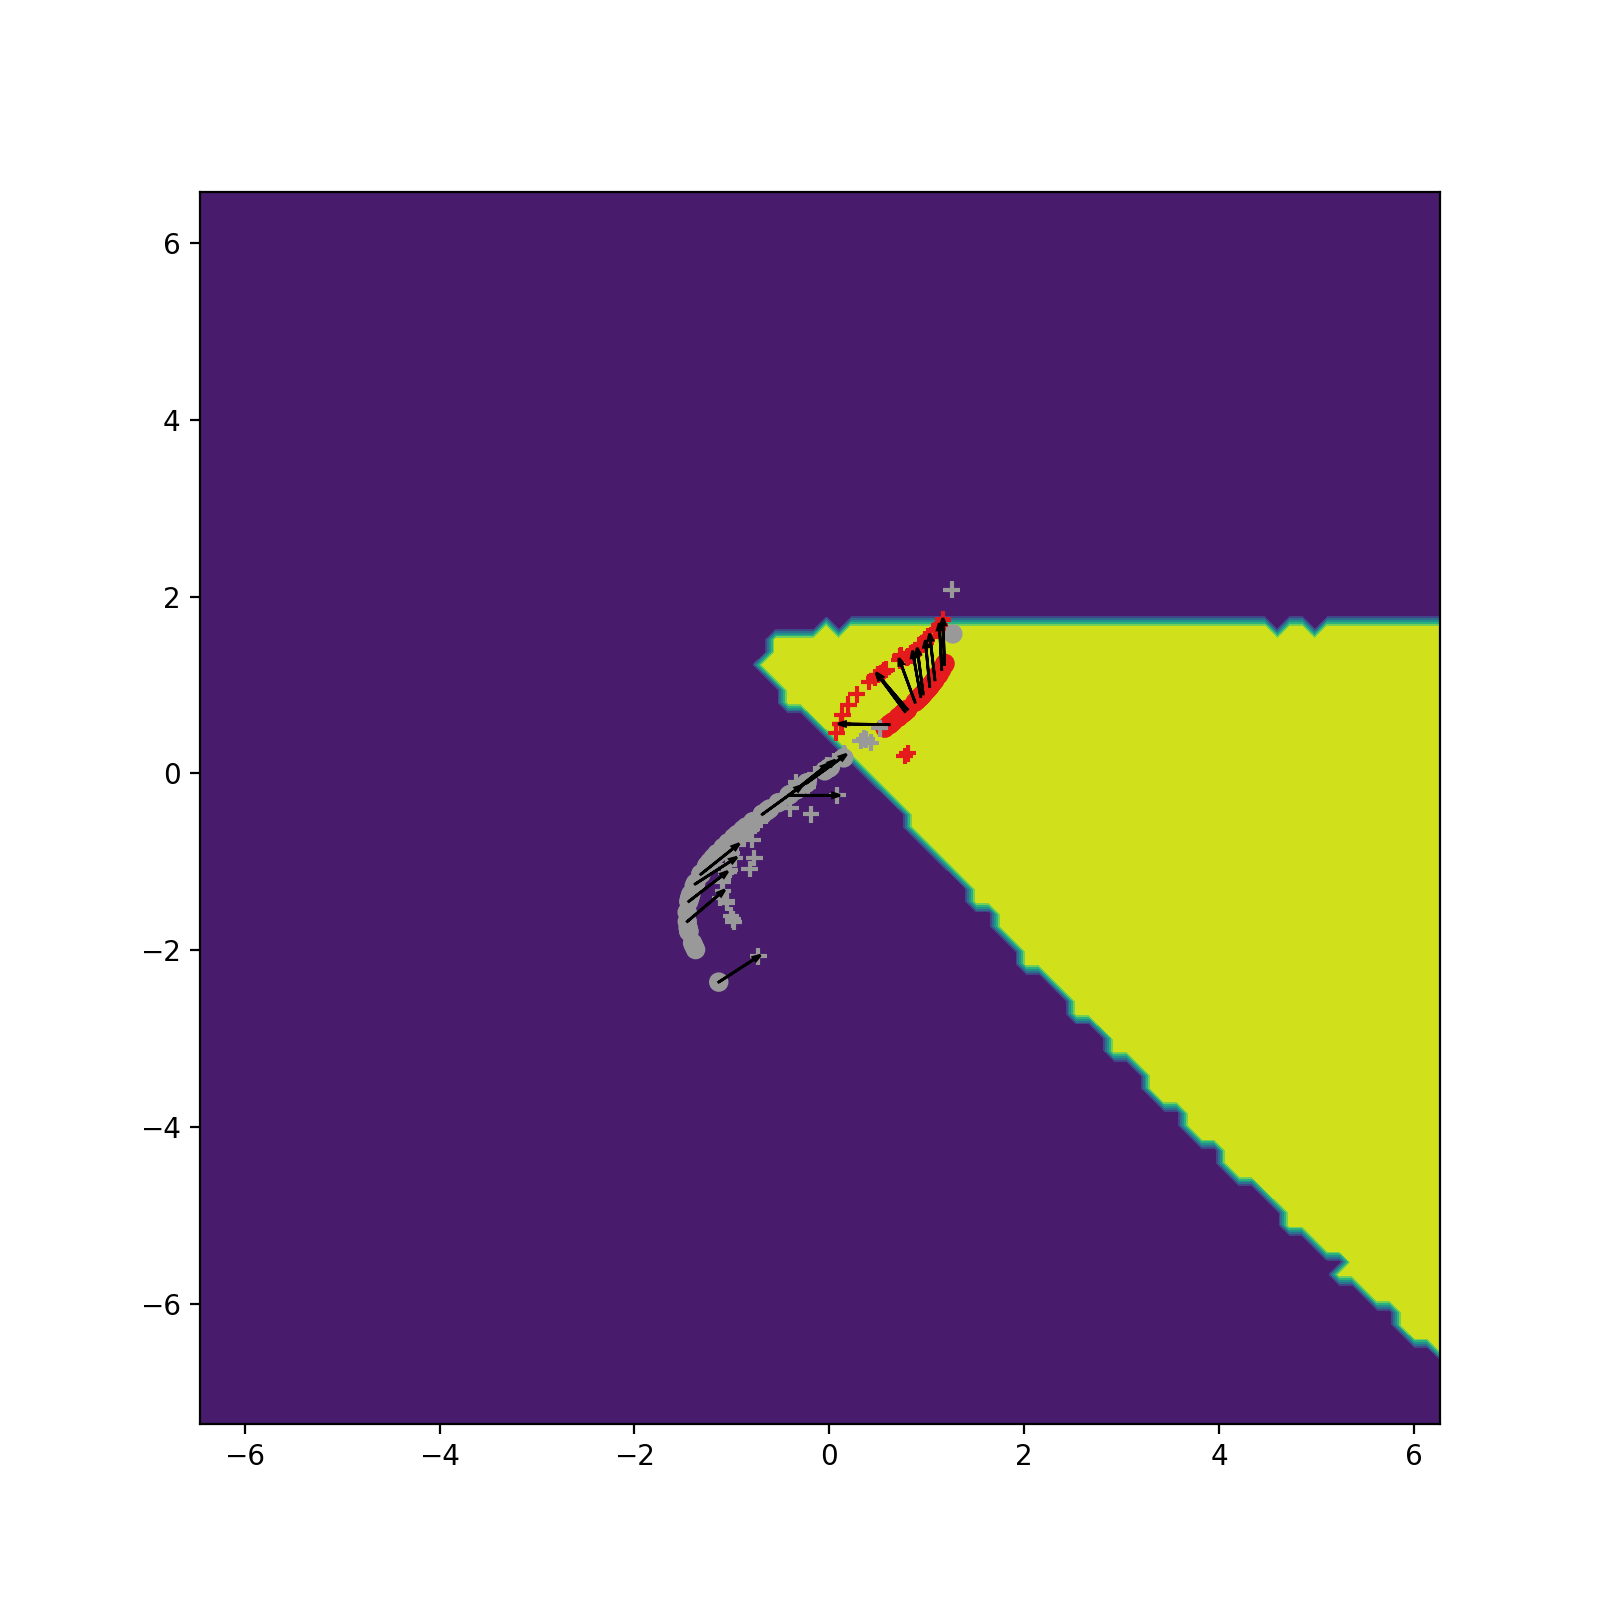

In [55]:
adv = fgm(inputs, predictions, eps = 0.5, ord = 2)
adv_points = adv.eval(session=K.get_session(),feed_dict={inputs: x})
plt.figure()
plt.contourf(xx,yy,plot_preds )
plt.scatter(data[:,0],data[:,1], c=labels , cmap=plt.cm.Set1_r); plt.show()

#draw some example arrows
for i in range(20):
    plt.arrow(data[i,0],data[i,1],
              (adv_points[i,0] - data[i,0]) * .9,
              (adv_points[i,1] - data[i,1]) * .9,
              head_width=0.05, fc='k')

plt.scatter(adv_points[:,0], adv_points[:,1], c=labels, marker='+',cmap=plt.cm.Set1_r); plt.show()

In the plots above and below, one can vary the choice of norms optimised by the method. This is equivalent to choosing our definition of what it means for an example to be 'adversarial'; we would say roughly that it is a point in X that is close to a correctly classified point x but is misclassified by our model. Making this a more formal statement requires choosing a norm to define 'closeness' with.
Interestingly, some points are pushed off the manifold the data lies on here. 
Some of the adversarial points have arrows connected them to the adversarial examples used to generate them; I didn't draw these for all of them becuase it gets confusing

<IPython.core.display.Javascript object>


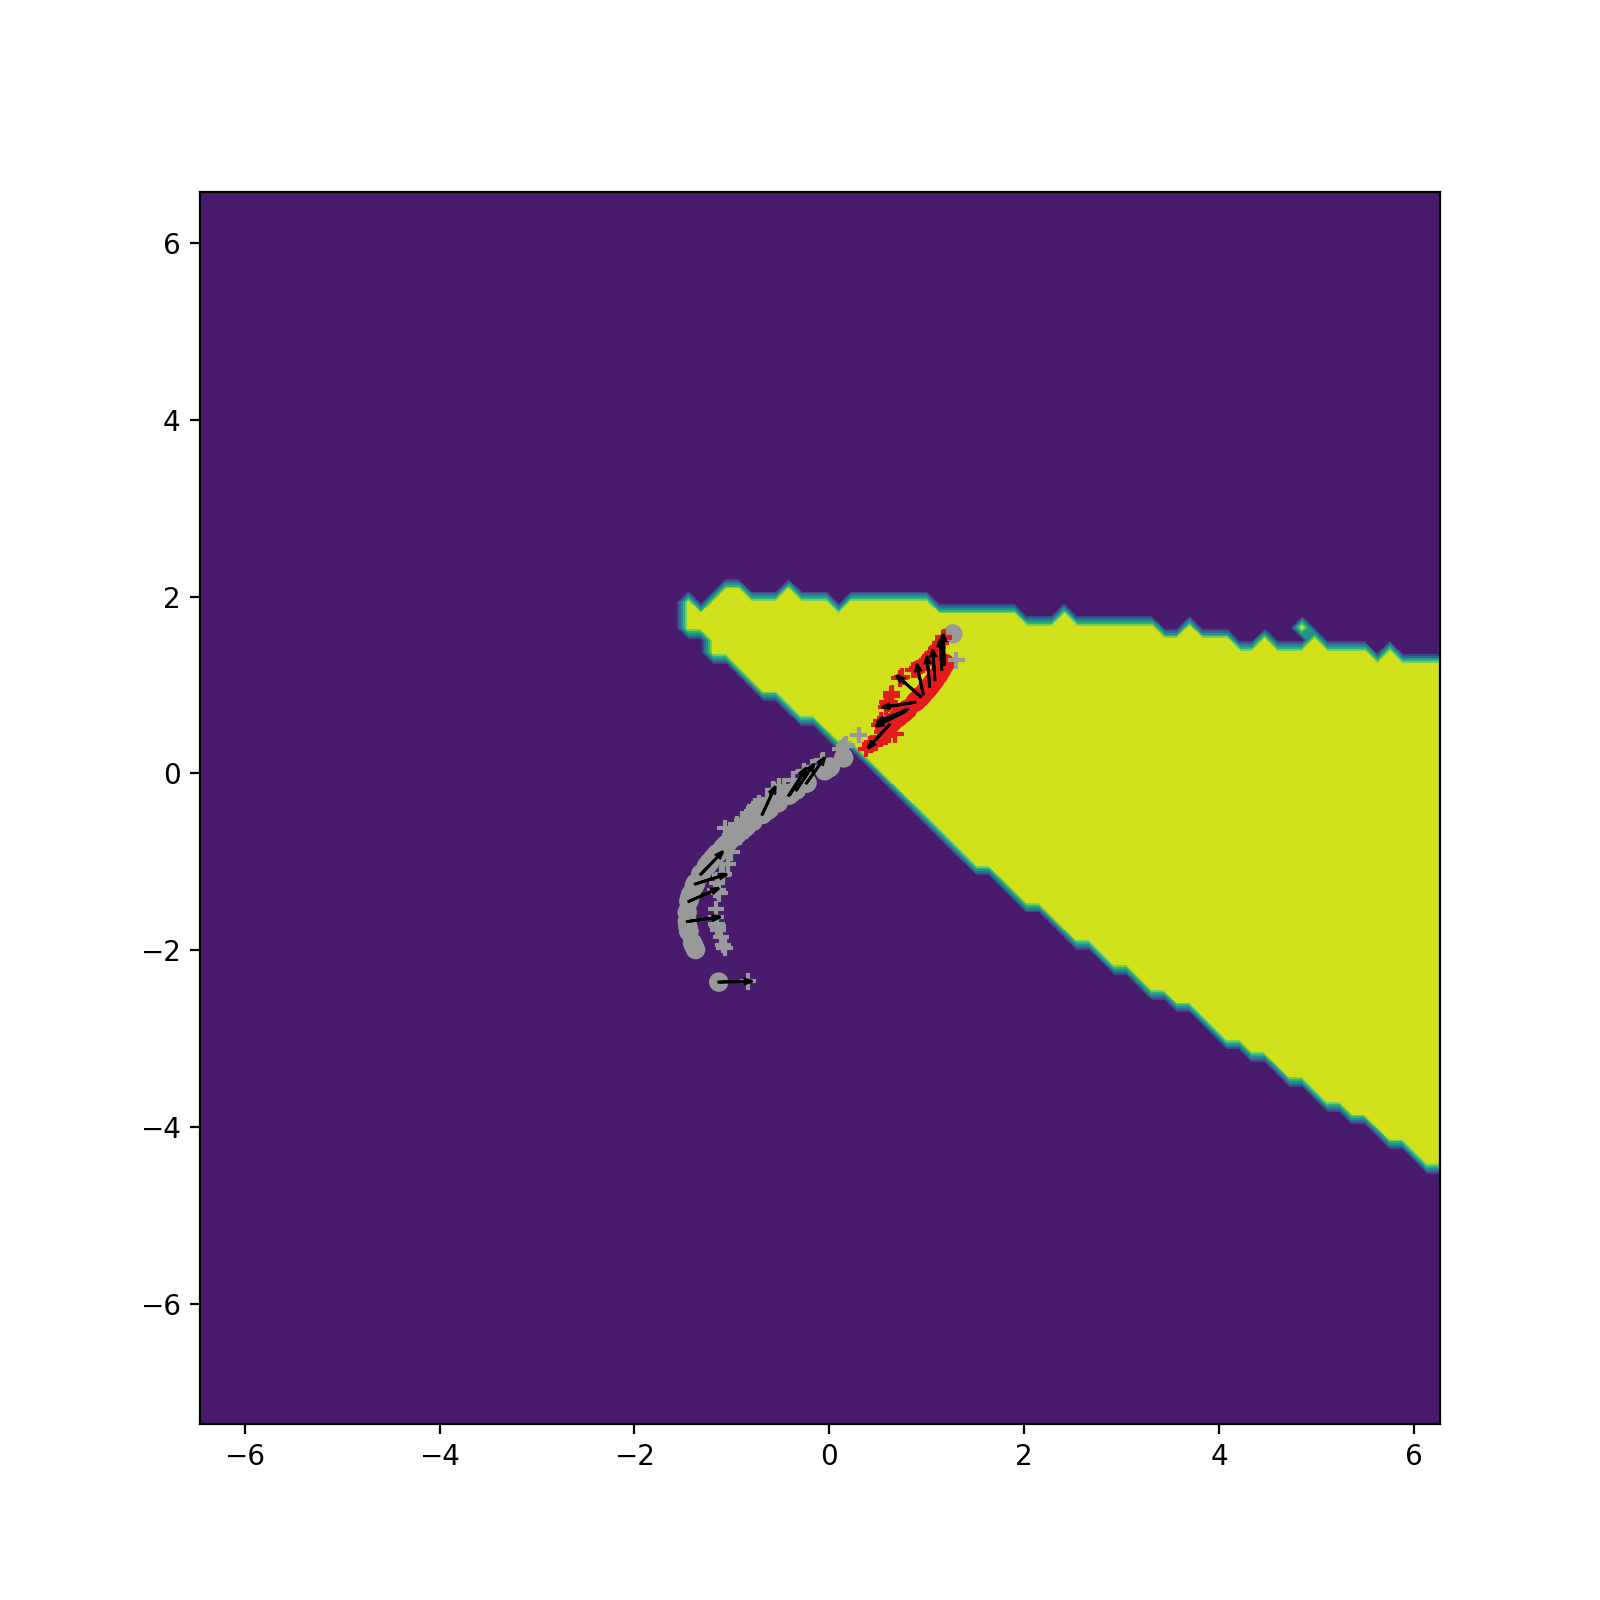

0.93999999999999995

In [65]:
#some messing around to get cleverhans to play with the mc model. Since this isn't implemented as a keras layer (yet?)
#some jiggery-pokery needs to be done so it looks like one enough to satisfy cleverhans' required interface.
from cleverhans.model import CallableModelWrapper
from cleverhans.attacks import BasicIterativeMethod
x = data
y = labels
def mc_model(x):
    #model is captured by closure.
    mc_preds_tensor = mc_dropout_preds(model, x, n_mc=n_mc)
    mean_preds = K.mean(mc_preds_tensor, axis=0)
    return mean_preds

wrapper = CallableModelWrapper(mc_model,'probs')
bim = BasicIterativeMethod(wrapper, sess=K.get_session())
adv = bim.generate(inputs, eps=.3, eps_iter = 0.1, nb_iter=10, ord=2)

adv_points = adv.eval(session=K.get_session(), feed_dict={inputs: x})

plt.figure()
plt.contourf(xx,yy,plot_preds )
plt.scatter(data[:,0],data[:,1], c=labels , cmap=plt.cm.Set1_r); plt.show()

#draw some example arrows
for i in range(20):
    plt.arrow(data[i,0],data[i,1],
              (adv_points[i,0] - data[i,0]) * .9,
              (adv_points[i,1] - data[i,1]) * .9,
              head_width=0.05, fc='k')

plt.scatter(adv_points[:,0], adv_points[:,1], c=labels, marker='+',cmap=plt.cm.Set1_r); plt.show()
sum(model.predict(adv_points).argmax(axis=1) == labels) / 100

In [66]:
#compare above plots to a GP classifier

import GPy as gp

kernel =gp.kern.MLP(2)
lik = gp.likelihoods.Bernoulli()
gp_model = gp.core.GP(X=data,
                      Y=labels.reshape(-1,1),
                      kernel=kernel,
                      inference_method=gp.inference.latent_function_inference.laplace.Laplace(),
                      likelihood=lik)
#optimise hyperparameters
print(gp_model)
for i in range(2):
    gp_model.optimize('bfgs', max_iters=100)
    print("iter:",i,gp_model)




Name : gp
Objective : 18.913977096592536
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                  |  value  |  constraints  |  priors
  mlp.variance         |    1.0  |      +ve      |        
  mlp.weight_variance  |    1.0  |      +ve      |        
  mlp.bias_variance    |    1.0  |      +ve      |        
iter: 0 
Name : gp
Objective : 8.057916887441161
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                  |          value  |  constraints  |  priors
  mlp.variance         |  163.421228756  |      +ve      |        
  mlp.weight_variance  |  60.1298481276  |      +ve      |        
  mlp.bias_variance    |  3.79173665066  |      +ve      |        
iter: 1 
Name : gp
Objective : 8.057916878552088
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                  |          value  |  constraints  |  priors
  mlp.variance     

<IPython.core.display.Javascript object>


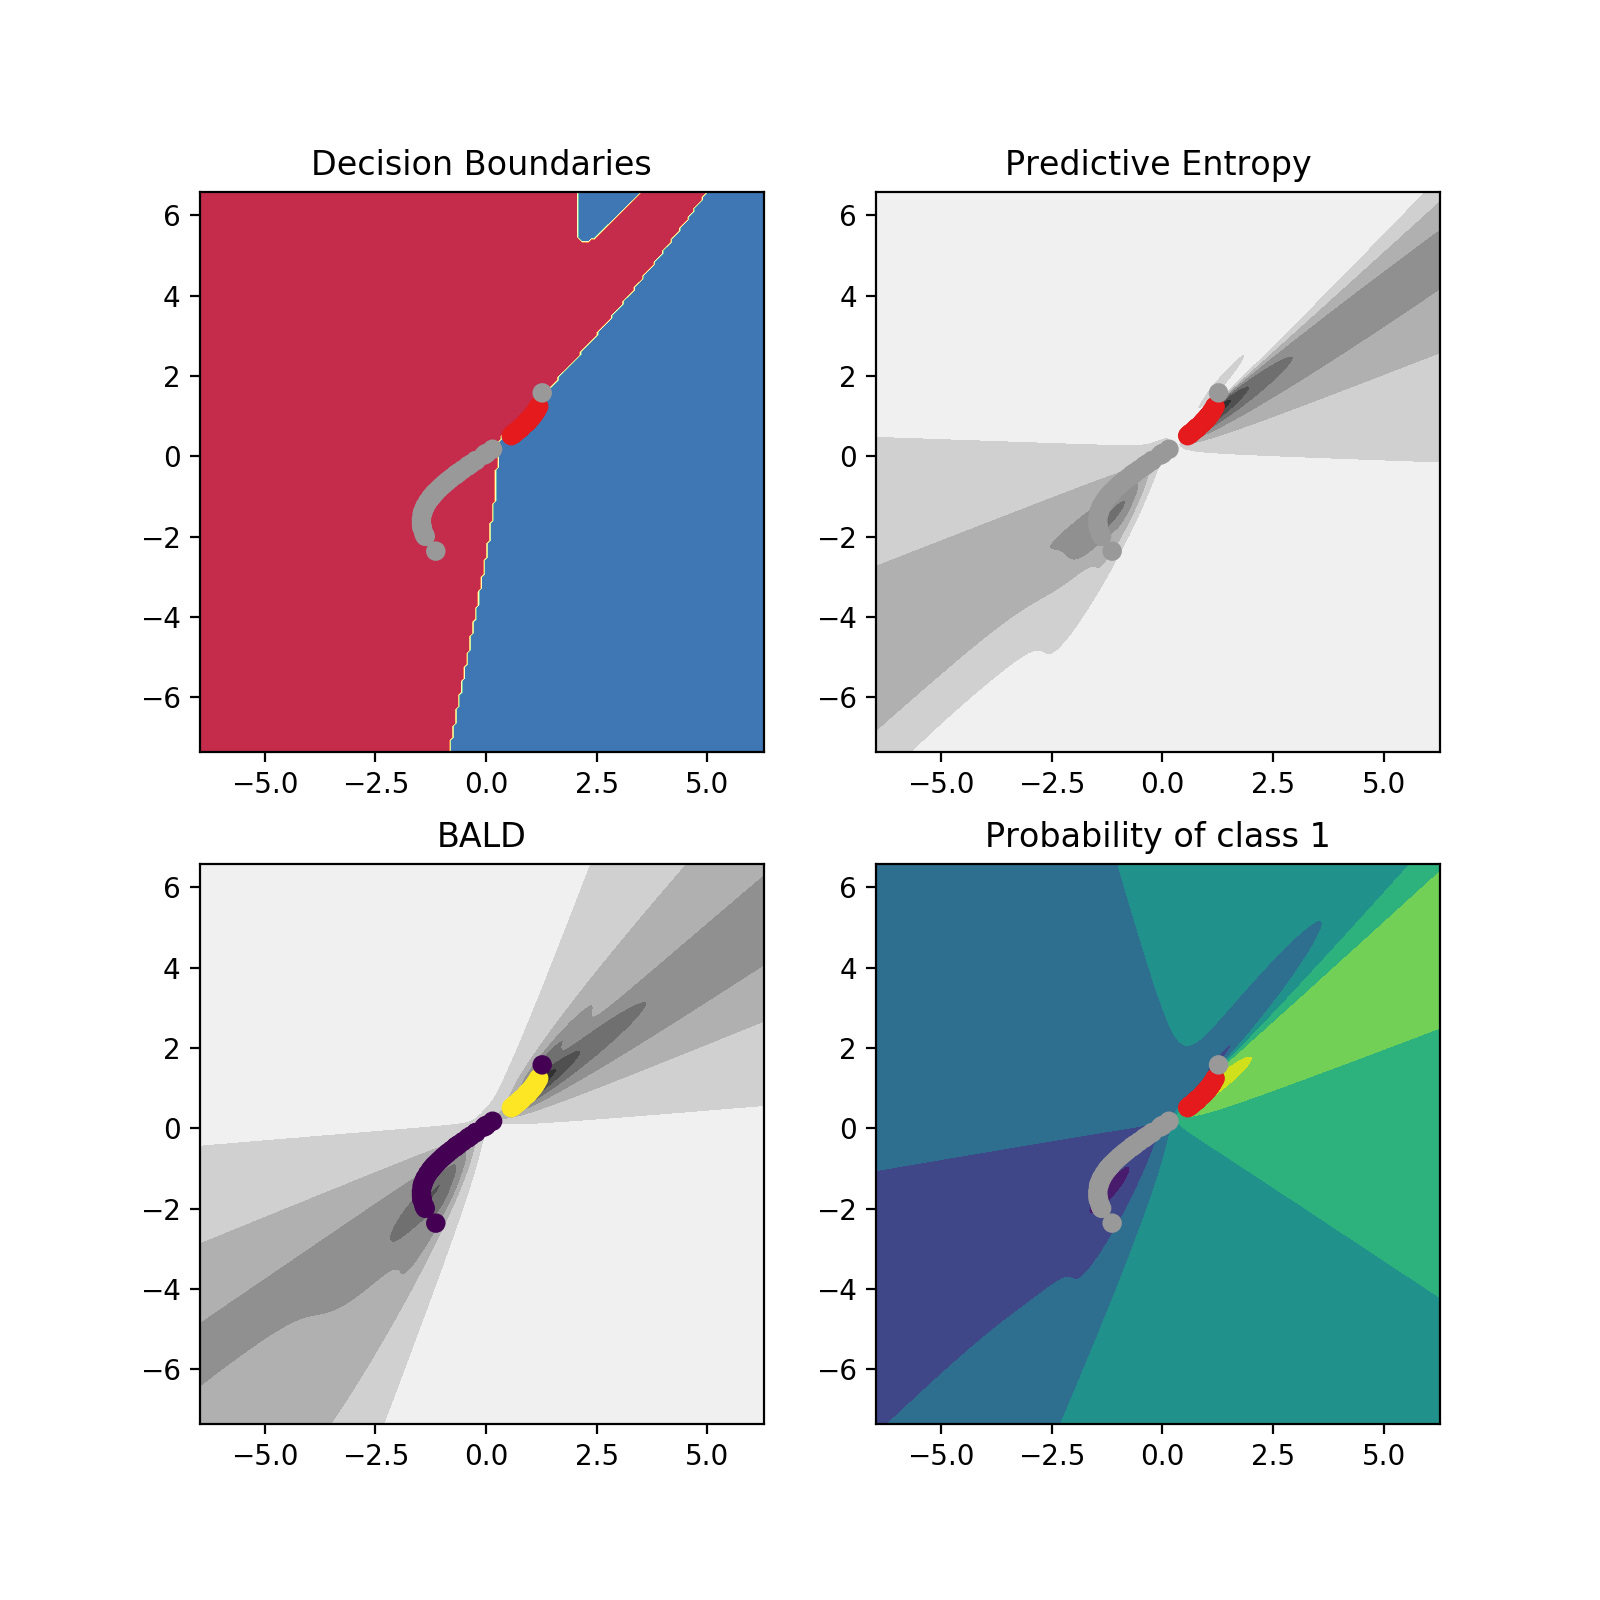

In [68]:

xx,yy = np.meshgrid(np.linspace(data[:,0].min() -5,data[:,0].max() + 5, 200),
                    np.linspace(data[:,1].min()-5,data[:,1].max()+5, 200))
plot_x = np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)], axis=1)
plot_probs,_ = gp_model.predict(plot_x)
f, ax = plt.subplots(2,2)
axlist = [x for x in ax.flatten()]

axlist[0].contourf(xx, yy, np.reshape(plot_probs > .5, xx.shape), cmap = plt.cm.Spectral)
axlist[0].scatter(data[:,0], data[:,1], c=labels, cmap=plt.cm.Set1_r)
axlist[0].set_title('Decision Boundaries')

axlist[3].contourf(xx,yy,plot_probs.reshape(xx.shape))
axlist[3].scatter(data[:,0], data[:,1], c = labels, cmap=plt.cm.Set1_r)
axlist[3].set_title('Probability of class 1')

entropy = - (plot_probs * np.log(plot_probs) + (1 - plot_probs) * np.log(1 - plot_probs))
#todo: make this a bit nicer.

axlist[1].contourf(xx,yy,entropy.reshape(xx.shape), cmap = 'gray')
axlist[1].scatter(data[:,0], data[:,1], c = labels, cmap=plt.cm.Set1_r)
axlist[1].set_title('Predictive Entropy')

#calculate the BALD for a GP; see Neil Houslby's thesis, section 3.2 
# https://www.repository.cam.ac.uk/bitstream/handle/1810/248885/HoulsbyThesis.pdf
l_m, l_v = gp_model.predict(plot_x, include_likelihood=False) #mean and variance of latent function
#approximate E(H(p(y|theta)))
C = np.sqrt(np.pi * np.log(2) /2)
expect_H = (1 / np.log2(np.e))  * C / (np.sqrt(l_v + C**2)) * np.exp( - l_m ** 2 / ( 2 * l_v + C**2))
bald = entropy - expect_H

axlist[2].contourf(xx,yy,bald.reshape(xx.shape), cmap = 'gray')
axlist[2].scatter(data[:,0], data[:,1], c = labels)
axlist[2].set_title('BALD')
plt.show()

Here, I plot analogous quantities for a GP with the 'neural network' kernel. The correspondece is not exact (the 'MLP' kernel corresponds to the limit of a single hidden layer neural network with (bounded) logistic activations and Gaussian priors over the weights. The uncertainty estimates here are qualitatively similar to those above, though the GP is more uncertain, as might be expected. 
I'm not sure how interesting this is really, but it suggests to me that whether we discover manifolds may be a function of our 'kernels' rather than neccesarily the bayesian treatment; even though a GP is doing more or less proper integration over it's uncertainty, with a non-stationary kernel it still produces regions of high certainty a measured by BALD far from the data. Maybe if we really want robust estimates of whether we are on the data manifold we have to do something more different? (e.g generative models or something)
As you pointed out, we could make the GP more uncertain far from the data by including a squared exp term or similar in the kernel, but that would make it un-neural-network like; I don't know if there is an analogy for neural nets. RBF acivations are a thing, but they don't work very well afaik. Not sure how much this tells us but i thought it was kinda interesting
